**Imports**

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from xgboost import plot_importance
import lightgbm as lgb

In [ ]:

!pip install category_encoders


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.1 MB/s eta 0:00:00




Loading the data

In [ ]:
df= pd.read_csv("/content/sales_Depi.csv")
df.head()

,Region,Country,Item Type,Sales Channel,Order Priority,Order Date,Order ID,Ship Date,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit
0,Sub-Saharan Africa,South Africa,Fruits,Offline,M,2012-07-27,443368995.0,2012-07-28,611265.0,38.26,12.67,23386998.90,7744727.55,15642271.35
1,Middle East and North Africa,Morocco,Clothes,Online,M,2013-09-14,667593514.0,2013-10-19,545518.0,145.65,79.81,79454696.70,43537791.58,35916905.12
2,Australia and Oceania,Papua New Guinea,Meat,Offline,M,2015-05-15,940995585.0,2015-06-04,326908.0,186.66,94.10,61020647.28,30762042.80,30258604.48
3,Sub-Saharan Africa,Djibouti,Clothes,Offline,H,2017-05-17,880811536.0,2017-07-02,431659.0,144.86,66.93,62530122.74,28890936.87,33639185.87
4,Europe,Slovakia,Beverages,Offline,L,2016-10-26,174590194.0,2016-12-04,625973.0,15.86,6.30,9927931.78,3943629.90,5984301.88


In [ ]:
df.columns

Index(['Region', 'Country', 'Item Type', 'Sales Channel', 'Order Priority',
       'Order Date', 'Order ID', 'Ship Date', 'Units Sold', 'Unit Price',
       'Unit Cost', 'Total Revenue', 'Total Cost', 'Total Profit'],
      dtype='object')

In [ ]:
df["Item Type"].unique()

array(['Fruits', 'Clothes', 'Meat', 'Beverages', 'Office Supplies',
       'Cosmetics', 'Snacks', 'Personal Care', 'Household', 'Vegetables',
       'Baby Food', 'Cereal', nan], dtype=object)

In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
##### for modeling ######
df_Baby_food=df[df["Item Type"]=='Baby Food'].copy()
df_Baby_food.shape

(81317, 14)

In [ ]:
df_Baby_food.columns

Index(['Region', 'Country', 'Item Type', 'Sales Channel', 'Order Priority',
       'Order Date', 'Order ID', 'Ship Date', 'Units Sold', 'Unit Price',
       'Unit Cost', 'Total Revenue', 'Total Cost', 'Total Profit'],
      dtype='object')

In [ ]:
df_Baby_food.drop_duplicates(inplace=True)
df_Baby_food['Order Date'] = pd.to_datetime(df_Baby_food['Order Date'])
df_Baby_food['Ship Date'] = pd.to_datetime(df_Baby_food['Ship Date'])


In [ ]:
df_Baby_food.head()

,Region,Country,Item Type,Sales Channel,Order Priority,Order Date,Order ID,Ship Date,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit
24,Central America and the Caribbean,Dominican Republic,Baby Food,Offline,H,2011-08-25,824714744.0,2011-09-24,409168.0,73.91,25.82,30241606.88,10564717.76,19676889.12
67,Europe,Iceland,Baby Food,Offline,M,2010-10-02,678230941.0,2010-11-03,372191.0,77.67,34.45,28908074.97,12821979.95,16086095.02
74,Australia and Oceania,Tonga,Baby Food,Online,L,2016-05-11,839094388.0,2016-05-31,430105.0,79.74,30.66,34296572.70,13187019.30,21109553.40
82,Europe,Albania,Baby Food,Offline,H,2012-07-19,752525556.0,2012-08-13,469245.0,83.65,35.59,39252344.25,16700429.55,22551914.70
84,Central America and the Caribbean,Nicaragua,Baby Food,Online,L,2016-11-11,343752610.0,2016-11-16,329017.0,76.17,34.96,25061224.89,11502434.32,13558790.57


In [ ]:
### encoding ####
from category_encoders import TargetEncoder
encoder = TargetEncoder()
df_Baby_food[["Region_encoded", "Country_encoded", "Sales Channel_encoded", "Order Priority_encoded"]] = encoder.fit_transform(
    df_Baby_food[["Region", "Country", "Sales Channel", "Order Priority"]],
    df_Baby_food["Units Sold"]
)

In [ ]:
df_Baby_food.head()

,Region,Country,Item Type,Sales Channel,Order Priority,Order Date,Order ID,Ship Date,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit,Region_encoded,Country_encoded,Sales Channel_encoded,Order Priority_encoded
24,Central America and the Caribbean,Dominican Republic,Baby Food,Offline,H,2011-08-25,824714744.0,2011-09-24,409168.0,73.91,25.82,30241606.88,10564717.76,19676889.12,355048.210934,357178.094688,357961.462627,417917.082171
67,Europe,Iceland,Baby Food,Offline,M,2010-10-02,678230941.0,2010-11-03,372191.0,77.67,34.45,28908074.97,12821979.95,16086095.02,359990.164393,351945.441805,357961.462627,369272.779199
74,Australia and Oceania,Tonga,Baby Food,Online,L,2016-05-11,839094388.0,2016-05-31,430105.0,79.74,30.66,34296572.70,13187019.30,21109553.40,355436.273987,352029.963719,358465.341335,335324.337993
82,Europe,Albania,Baby Food,Offline,H,2012-07-19,752525556.0,2012-08-13,469245.0,83.65,35.59,39252344.25,16700429.55,22551914.70,359990.164393,357330.946067,357961.462627,417917.082171
84,Central America and the Caribbean,Nicaragua,Baby Food,Online,L,2016-11-11,343752610.0,2016-11-16,329017.0,76.17,34.96,25061224.89,11502434.32,13558790.57,355048.210934,352364.926773,358465.341335,335324.337993


In [ ]:
df_Baby_food.columns

Index(['Region', 'Country', 'Item Type', 'Sales Channel', 'Order Priority',
       'Order Date', 'Order ID', 'Ship Date', 'Units Sold', 'Unit Price',
       'Unit Cost', 'Total Revenue', 'Total Cost', 'Total Profit',
       'Region_encoded', 'Country_encoded', 'Sales Channel_encoded',
       'Order Priority_encoded'],
      dtype='object')

In [ ]:
# Convert to datetime
df_Baby_food["Order Date"] = pd.to_datetime(df_Baby_food["Order Date"])
df_Baby_food["Ship Date"] = pd.to_datetime(df_Baby_food["Ship Date"])

# Date parts
df_Baby_food["Day"] = df_Baby_food["Order Date"].dt.day
df_Baby_food["Year"] = df_Baby_food["Order Date"].dt.year
df_Baby_food["Month"] = df_Baby_food["Order Date"].dt.month
df_Baby_food["DayOfWeek"] = df_Baby_food["Order Date"].dt.dayofweek
df_Baby_food["IsWeekend"] = (df_Baby_food["DayOfWeek"] >= 5).astype(int)

# Sort by date
df_Baby_food = df_Baby_food.sort_values(by='Order Date')

# Quarter
df_Baby_food["Quarter"] = df_Baby_food["Order Date"].dt.quarter

# Shipping delay in days
df_Baby_food["Shipping Delay"] = (df_Baby_food["Ship Date"] - df_Baby_food["Order Date"]).dt.days


In [ ]:
df_Baby_food.columns

Index(['Region', 'Country', 'Item Type', 'Sales Channel', 'Order Priority',
       'Order Date', 'Order ID', 'Ship Date', 'Units Sold', 'Unit Price',
       'Unit Cost', 'Total Revenue', 'Total Cost', 'Total Profit',
       'Region_encoded', 'Country_encoded', 'Sales Channel_encoded',
       'Order Priority_encoded', 'Day', 'Year', 'Month', 'DayOfWeek',
       'IsWeekend', 'Quarter', 'Shipping Delay'],
      dtype='object')

In [ ]:
df_Baby_food.drop(["Order Date","Total Cost","Total Profit","Ship Date"],axis=1,inplace=True)

In [ ]:
df_Baby_food.head(10)

,Region,Country,Item Type,Sales Channel,Order Priority,Order ID,Units Sold,Unit Price,Unit Cost,Total Revenue,...,Country_encoded,Sales Channel_encoded,Order Priority_encoded,Day,Year,Month,DayOfWeek,IsWeekend,Quarter,Shipping Delay
68611,Europe,Ukraine,Baby Food,Online,M,840909707.0,461193.0,81.10,33.29,37402752.30,...,429875.872247,358465.341335,369272.779199,1,2010,1,4,0,1,47
728272,Sub-Saharan Africa,South Sudan,Baby Food,Online,L,587325942.0,284141.0,79.97,30.37,22722755.77,...,352386.233333,358465.341335,335324.337993,1,2010,1,4,0,1,6
257735,Asia,Thailand,Baby Food,Online,M,433514773.0,390651.0,83.76,32.52,32720927.76,...,364728.370787,358465.341335,369272.779199,1,2010,1,4,0,1,7
85494,Sub-Saharan Africa,Sudan,Baby Food,Online,M,302570617.0,279512.0,80.53,35.75,22509101.36,...,363567.785714,358465.341335,369272.779199,1,2010,1,4,0,1,1
634728,Asia,Bangladesh,Baby Food,Offline,C,818042695.0,250248.0,73.81,30.85,18470804.88,...,350672.798246,357961.462627,311126.900414,1,2010,1,4,0,1,4
579183,Central America and the Caribbean,Grenada,Baby Food,Online,H,608028304.0,296135.0,73.06,29.06,21635623.10,...,354375.691076,358465.341335,417917.082171,1,2010,1,4,0,1,50
274231,Europe,Finland,Baby Food,Online,H,431350123.0,460357.0,87.47,38.18,40267426.79,...,365614.273333,358465.341335,417917.082171,1,2010,1,4,0,1,8
333794,Central America and the Caribbean,Saint Kitts and Nevis,Baby Food,Offline,L,171626460.0,318359.0,74.33,31.74,23663624.47,...,360863.637232,357961.462627,335324.337993,1,2010,1,4,0,1,45
850024,Europe,Russia,Baby Food,Offline,H,662066876.0,332543.0,78.02,35.81,25945004.86,...,355233.563218,357961.462627,417917.082171,1,2010,1,4,0,1,6
641646,Sub-Saharan Africa,Rwanda,Baby Food,Offline,C,738972461.0,262152.0,82.77,34.02,21698321.04,...,355030.591647,357961.462627,311126.900414,1,2010,1,4,0,1,5


In [ ]:
df_Baby_food.describe()

,Order ID,Units Sold,Unit Price,Unit Cost,Total Revenue,Region_encoded,Country_encoded,Sales Channel_encoded,Order Priority_encoded,Day,Year,Month,DayOfWeek,IsWeekend,Quarter,Shipping Delay
count,8.131700e+04,81317.000000,81317.000000,81317.000000,8.131700e+04,81317.000000,81317.000000,81317.000000,81317.000000,81317.000000,81317.00000,81317.000000,81317.000000,81317.000000,81317.000000,81317.000000
mean,5.490348e+08,358213.652938,79.995196,32.002928,2.865628e+07,358213.652938,358213.652938,358213.652938,358213.652938,15.714832,2013.30284,6.319540,3.003357,0.286693,2.445307,25.035626
std,2.606086e+08,70342.734486,4.622826,3.342612,5.875693e+06,2016.203861,12914.570587,251.940778,40094.926846,8.786310,2.19598,3.422453,1.999742,0.452220,1.110911,14.736437
min,1.000012e+08,131657.000000,72.000000,24.510000,1.001120e+07,355048.210934,342435.271335,357961.462627,311126.900414,1.000000,2010.00000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,3.235948e+08,308799.000000,75.980000,29.490000,2.450146e+07,356450.111769,352606.924171,357961.462627,311126.900414,8.000000,2011.00000,3.000000,1.000000,0.000000,1.000000,12.000000
50%,5.483622e+08,353449.000000,79.990000,31.890000,2.820528e+07,359990.164393,356608.071910,358465.341335,335324.337993,16.000000,2013.00000,6.000000,3.000000,0.000000,2.000000,25.000000
75%,7.746390e+08,402416.000000,84.000000,34.420000,3.236141e+07,360121.202649,360178.901602,358465.341335,369272.779199,23.000000,2015.00000,9.000000,5.000000,1.000000,3.000000,38.000000
max,9.999909e+08,742142.000000,88.000000,40.430000,6.163457e+07,360121.202649,431881.803132,358465.341335,417917.082171,31.000000,2017.00000,12.000000,6.000000,1.000000,4.000000,50.000000


In [ ]:
df_Baby_food['Lag_1D'] = df_Baby_food['Units Sold'].shift(1)
df_Baby_food['Lag_7D'] = df_Baby_food['Units Sold'].shift(7)
df_Baby_food['Lag_1'] = df_Baby_food['Units Sold'].shift(30)
df_Baby_food['Lag_14D'] = df_Baby_food['Units Sold'].shift(14)
df_Baby_food['Lag_21D'] = df_Baby_food['Units Sold'].shift(21)


df_Baby_food['Lag_1D_rev'] = df_Baby_food['Total Revenue'].shift(1)
df_Baby_food['Lag_7D_rev'] = df_Baby_food['Total Revenue'].shift(7)

df_Baby_food = df_Baby_food.dropna()


In [ ]:
# Compute 7-row and 30-row rolling averages (assumes ~daily data)
df_Baby_food['Rolling_7D'] = df_Baby_food['Units Sold'].rolling(window=7).mean()
df_Baby_food['Rolling_1M'] = df_Baby_food['Units Sold'].rolling(window=30).mean()
df_Baby_food['Rolling_2M'] = df_Baby_food['Units Sold'].rolling(window=60).mean()
df_Baby_food['Rolling_3M'] = df_Baby_food['Units Sold'].rolling(window=90).mean()

df_Baby_food['Rolling_7d_Avg_rev'] = df_Baby_food['Total Revenue'].rolling(window=7).mean()
df_Baby_food['Rolling_30d_Avg_rev'] = df_Baby_food['Total Revenue'].rolling(window=30).mean()
df_Baby_food['Rolling_60d_Avg_rev'] = df_Baby_food['Total Revenue'].rolling(window=60).mean()
df_Baby_food['Rolling_90d_Avg_rev'] = df_Baby_food['Total Revenue'].rolling(window=90).mean()



<ipython-input-21-3679cb1d1816>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Baby_food['Rolling_7D'] = df_Baby_food['Units Sold'].rolling(window=7).mean()
<ipython-input-21-3679cb1d1816>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Baby_food['Rolling_1M'] = df_Baby_food['Units Sold'].rolling(window=30).mean()
<ipython-input-21-3679cb1d1816>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [ ]:
df_Baby_food.describe()

,Order ID,Units Sold,Unit Price,Unit Cost,Total Revenue,Region_encoded,Country_encoded,Sales Channel_encoded,Order Priority_encoded,Day,...,Lag_1D_rev,Lag_7D_rev,Rolling_7D,Rolling_1M,Rolling_2M,Rolling_3M,Rolling_7d_Avg_rev,Rolling_30d_Avg_rev,Rolling_60d_Avg_rev,Rolling_90d_Avg_rev
count,8.128700e+04,81287.000000,81287.000000,81287.000000,8.128700e+04,81287.000000,81287.000000,81287.000000,81287.000000,81287.000000,...,8.128700e+04,8.128700e+04,81281.000000,81258.000000,81228.000000,81198.000000,8.128100e+04,8.125800e+04,8.122800e+04,8.119800e+04
mean,5.490266e+08,358225.967572,79.995214,32.002782,2.865725e+07,358213.450180,358213.292963,358213.659230,358215.225279,15.720152,...,2.865722e+07,2.865696e+07,358227.221997,358228.197971,358228.615640,358229.622351,2.865738e+07,2.865747e+07,2.865756e+07,2.865767e+07
std,2.606113e+08,70342.709665,4.623122,3.342637,5.875609e+06,2016.254046,12914.165974,251.940772,40096.120022,8.783561,...,5.875633e+06,5.875701e+06,28107.022395,16212.000593,13503.610186,12486.801460,2.336987e+06,1.331817e+06,1.102710e+06,1.015376e+06
min,1.000012e+08,131657.000000,72.000000,24.510000,1.001120e+07,355048.210934,342435.271335,357961.462627,311126.900414,1.000000,...,1.001120e+07,1.001120e+07,256398.571429,309858.100000,322144.366667,325365.722222,2.001702e+07,2.450067e+07,2.554056e+07,2.609122e+07
25%,3.235818e+08,308822.000000,75.980000,29.490000,2.450272e+07,356450.111769,352606.924171,357961.462627,311126.900414,8.000000,...,2.450272e+07,2.450259e+07,339118.428571,347631.858333,349854.500000,350753.025000,2.706092e+07,2.778799e+07,2.796893e+07,2.804584e+07
50%,5.483588e+08,353460.000000,79.990000,31.890000,2.820735e+07,359990.164393,356608.071910,358465.341335,335324.337993,16.000000,...,2.820735e+07,2.820568e+07,357037.285714,356467.333333,356126.850000,356060.583333,2.855581e+07,2.851060e+07,2.848647e+07,2.847823e+07
75%,7.746373e+08,402432.500000,84.000000,34.420000,3.236292e+07,360121.202649,360178.901602,358465.341335,369272.779199,23.000000,...,3.236292e+07,3.236228e+07,375869.857143,366392.466667,363454.770833,362115.797222,3.012280e+07,2.934705e+07,2.908823e+07,2.898652e+07
max,9.999909e+08,742142.000000,88.000000,40.430000,6.163457e+07,360121.202649,431881.803132,358465.341335,417917.082171,31.000000,...,6.163457e+07,6.163457e+07,520539.714286,442330.933333,424627.783333,413507.600000,4.296307e+07,3.554823e+07,3.393452e+07,3.324202e+07


In [ ]:
df_Baby_food.dropna(inplace=True)


In [ ]:

df_Baby_food.columns

Index(['Region', 'Country', 'Item Type', 'Sales Channel', 'Order Priority',
       'Order ID', 'Units Sold', 'Unit Price', 'Unit Cost', 'Total Revenue',
       'Region_encoded', 'Country_encoded', 'Sales Channel_encoded',
       'Order Priority_encoded', 'Day', 'Year', 'Month', 'DayOfWeek',
       'IsWeekend', 'Quarter', 'Shipping Delay', 'Lag_1D', 'Lag_7D', 'Lag_1',
       'Lag_14D', 'Lag_21D', 'Lag_1D_rev', 'Lag_7D_rev', 'Rolling_7D',
       'Rolling_1M', 'Rolling_2M', 'Rolling_3M', 'Rolling_7d_Avg_rev',
       'Rolling_30d_Avg_rev', 'Rolling_60d_Avg_rev', 'Rolling_90d_Avg_rev'],
      dtype='object')

In [ ]:
# Choose features
features = ['Region_encoded', 'Country_encoded', 'Sales Channel_encoded', 'Order Priority_encoded',
       'Unit Price', 'Unit Cost', 'Shipping Delay', 'Year',
       'Month', 'Day', 'DayOfWeek', 'IsWeekend', 'Rolling_7D',
       'Rolling_1M', 'Lag_1D', 'Lag_7D',
       'Lag_1', 'Lag_14D', 'Lag_21D',"Lag_1D_rev","Lag_7D_rev"
           ]

In [ ]:
train_size = int(len(df_Baby_food) * 0.6)
val_size = int(len(df_Baby_food) * 0.8)
train, validate,test = df_Baby_food[:train_size],df_Baby_food[train_size:val_size] ,df_Baby_food[val_size:]

X_train = train[features]
y_train = train["Units Sold"]
X_cv = validate[features]
y_cv = validate["Units Sold"]
X_test = test[features]
y_test = test["Units Sold"]
# y_train_log = np.log1p(y_train)

# y_test_log = np.log1p(y_test)g

In [ ]:

from sklearn.linear_model import LinearRegression
model=LinearRegression()
model.fit(X_train, y_train)



LinearRegression()

In [ ]:

cv_predictions = model.predict(X_cv)
predictions = model.predict(X_test)



In [ ]:
from sklearn.metrics import mean_squared_error,r2_score
r2 = r2_score(y_cv, cv_predictions)
print("validation R² Score:", r2)
mse = mean_squared_error(y_cv, cv_predictions)
print("Validation MSE:", mse)

print("------------------")

r2 = r2_score(y_test, predictions)
print(" Test R² Score:", r2)
mse = mean_squared_error(y_test, predictions)
print("Test MSE:", mse)

validation R² Score: 0.4498086735692659
Validation MSE: 2748089605.956475
------------------
 Test R² Score: 0.4445608820006328
Test MSE: 2724562414.7930393


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler



model = RandomForestRegressor(n_estimators=100, random_state=42) # You can tune n_estimators
model.fit(X_train, y_train)
predictions = model.predict(X_test)






In [ ]:
cv_predictions = model.predict(X_cv)
predictions = model.predict(X_test)



In [ ]:
from sklearn.metrics import mean_squared_error,r2_score
r2 = r2_score(y_cv, cv_predictions)
print("validation R² Score:", r2)
mse = mean_squared_error(y_cv, cv_predictions)
print("Validation MSE:", mse)

print("------------------")

r2 = r2_score(y_test, predictions)
print(" Test R² Score:", r2)
mse = mean_squared_error(y_test, predictions)
print("Test MSE:", mse)

validation R² Score: 0.4549319770224385
Validation MSE: 2722499786.0311747
------------------
 Test R² Score: 0.454205681857075
Test MSE: 2677252352.653892


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
import pickle
model = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=3)
model.fit(X_train, y_train)


predictions = model.predict(X_test)
data_to_save = {
    'model': model,
    'feature_names': X_train.columns.tolist()
}

with open("xgb_model_baby_food.pkl", "wb") as f:
    pickle.dump(data_to_save, f)




In [ ]:



cv_predictions = model.predict(X_cv)
predictions = model.predict(X_test)



In [ ]:

from sklearn.metrics import mean_squared_error,r2_score
r2 = r2_score(y_cv, cv_predictions)
print("validation R² Score:", r2)
mse = mean_squared_error(y_cv, cv_predictions)
print("Validation MSE:", mse)

print("------------------")

r2 = r2_score(y_test, predictions)
print(" Test R² Score:", r2)
mse = mean_squared_error(y_test, predictions)
print("Test MSE:", mse)



validation R² Score: 0.47031863924469663
Validation MSE: 2645646654.2348957
------------------
 Test R² Score: 0.46728381601047275
Test MSE: 2613100960.3315215


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50,100, 200,300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
}

xgb = XGBRegressor(random_state=42)
grid = GridSearchCV(xgb, param_grid, cv=None, scoring='r2', verbose=1)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
best_model = grid.best_estimator_



Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}


In [ ]:
cv_predictions = model.predict(X_cv)
predictions = model.predict(X_test)



In [ ]:
from sklearn.metrics import mean_squared_error,r2_score
r2 = r2_score(y_cv, cv_predictions)
print("validation R² Score:", r2)
mse = mean_squared_error(y_cv, cv_predictions)
print("Validation MSE:", mse)

print("------------------")

r2 = r2_score(y_test, predictions)
print(" Test R² Score:", r2)
mse = mean_squared_error(y_test, predictions)
print("Test MSE:", mse)


validation R² Score: 0.47031863924469663
Validation MSE: 2645646654.2348957
------------------
 Test R² Score: 0.46728381601047275
Test MSE: 2613100960.3315215


In [ ]:
model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    early_stopping_rounds=50,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=10
)


y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² Score:", r2_score(y_test, y_pred))

[0]	validation_0-rmse:68507.75139
[10]	validation_0-rmse:58461.21541
[20]	validation_0-rmse:54209.89486
[30]	validation_0-rmse:52476.70822
[40]	validation_0-rmse:51748.25186
[50]	validation_0-rmse:51437.16918
[60]	validation_0-rmse:51306.30312
[70]	validation_0-rmse:51229.54115
[80]	validation_0-rmse:51191.35320
[90]	validation_0-rmse:51187.58661
[100]	validation_0-rmse:51181.92754
[110]	validation_0-rmse:51181.77495
[120]	validation_0-rmse:51181.65200
[130]	validation_0-rmse:51189.04976
[140]	validation_0-rmse:51202.41439
[150]	validation_0-rmse:51210.43069
[160]	validation_0-rmse:51217.15040
[165]	validation_0-rmse:51217.33331
MAE: 40463.55816656404
RMSE: 51177.24857621755
R² Score: 0.46605863416805193


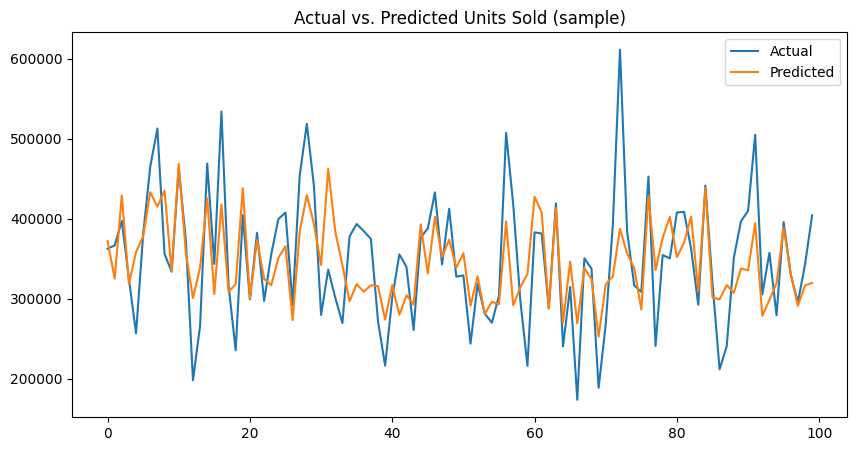

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test.values[:100], label='Actual')
plt.plot(predictions[:100], label='Predicted')
plt.legend()
plt.title("Actual vs. Predicted Units Sold (sample)")
plt.show()



In [ ]:
##### for modeling ######
df_Clothes=df[df["Item Type"]=='Clothes'].copy()
df_Clothes.shape

(81289, 14)

In [ ]:
df_Clothes.columns

Index(['Region', 'Country', 'Item Type', 'Sales Channel', 'Order Priority',
       'Order Date', 'Order ID', 'Ship Date', 'Units Sold', 'Unit Price',
       'Unit Cost', 'Total Revenue', 'Total Cost', 'Total Profit'],
      dtype='object')

In [ ]:

df_Clothes.drop_duplicates(inplace=True)
df_Clothes['Order Date'] = pd.to_datetime(df_Clothes['Order Date'])
df_Clothes['Ship Date'] = pd.to_datetime(df_Clothes['Ship Date'])


In [ ]:
### encoding ####
from category_encoders import TargetEncoder
encoder = TargetEncoder()
df_Clothes[["Region_encoded", "Country_encoded", "Sales Channel_encoded", "Order Priority_encoded"]] = encoder.fit_transform(
    df_Clothes[["Region", "Country", "Sales Channel", "Order Priority"]],
    df_Clothes["Units Sold"]
)

In [ ]:

df_Clothes.drop(["Item Type","Order ID"],axis=1,inplace=True)

In [ ]:

df_Clothes.columns

Index(['Region', 'Country', 'Sales Channel', 'Order Priority', 'Order Date',
       'Ship Date', 'Units Sold', 'Unit Price', 'Unit Cost', 'Total Revenue',
       'Total Cost', 'Total Profit', 'Region_encoded', 'Country_encoded',
       'Sales Channel_encoded', 'Order Priority_encoded'],
      dtype='object')

In [ ]:
# Convert to datetime
df_Clothes["Order Date"] = pd.to_datetime(df_Clothes["Order Date"])
df_Clothes["Ship Date"] = pd.to_datetime(df_Clothes["Ship Date"])

# Date parts
df_Clothes["Day"] = df_Clothes["Order Date"].dt.day
df_Clothes["Year"] = df_Clothes["Order Date"].dt.year
df_Clothes["Month"] = df_Clothes["Order Date"].dt.month
df_Clothes["DayOfWeek"] = df_Clothes["Order Date"].dt.dayofweek
df_Clothes["IsWeekend"] = (df_Clothes["DayOfWeek"] >= 5).astype(int)

# Sort by date
df_Clothes = df_Clothes.sort_values(by='Order Date')

# Quarter
df_Clothes["Quarter"] = df_Clothes["Order Date"].dt.quarter

# Shipping delay in days
df_Clothes["Shipping Delay"] = (df_Clothes["Ship Date"] - df_Clothes["Order Date"]).dt.days

In [ ]:
df_Clothes.columns

Index(['Region', 'Country', 'Sales Channel', 'Order Priority', 'Order Date',
       'Ship Date', 'Units Sold', 'Unit Price', 'Unit Cost', 'Total Revenue',
       'Total Cost', 'Total Profit', 'Region_encoded', 'Country_encoded',
       'Sales Channel_encoded', 'Order Priority_encoded', 'Day', 'Year',
       'Month', 'DayOfWeek', 'IsWeekend', 'Quarter', 'Shipping Delay'],
      dtype='object')

In [ ]:
df_Clothes.drop(["Order Date","Total Cost","Total Profit","Ship Date"],axis=1,inplace=True)

In [ ]:
df_Clothes.head(10)

,Region,Country,Sales Channel,Order Priority,Units Sold,Unit Price,Unit Cost,Total Revenue,Region_encoded,Country_encoded,Sales Channel_encoded,Order Priority_encoded,Day,Year,Month,DayOfWeek,IsWeekend,Quarter,Shipping Delay
435991,Sub-Saharan Africa,Liberia,Offline,M,517885.0,150.23,64.98,77801863.55,386479.475629,399750.274157,385210.610005,397631.813767,1,2010,1,4,0,1,47
512227,Middle East and North Africa,Oman,Online,C,308203.0,163.84,86.50,50495979.52,382120.057704,372264.863529,385133.032111,335183.053414,1,2010,1,4,0,1,2
924273,Australia and Oceania,Kiribati,Online,L,381806.0,161.76,85.35,61760938.56,382590.089896,376403.059226,385133.032111,359455.253594,1,2010,1,4,0,1,0
370811,Europe,Bulgaria,Online,L,377647.0,153.47,65.83,57957485.09,388178.032864,390531.292784,385133.032111,359455.253594,1,2010,1,4,0,1,4
756826,Sub-Saharan Africa,Tanzania,Online,M,552503.0,158.33,89.21,87477799.99,386479.475629,391548.477679,385133.032111,397631.813767,1,2010,1,4,0,1,10
922187,Sub-Saharan Africa,Cote d'Ivoire,Online,M,458548.0,149.55,74.96,68575853.40,386479.475629,385397.335570,385133.032111,397631.813767,1,2010,1,4,0,1,45
697871,Asia,Kyrgyzstan,Online,C,335949.0,161.34,92.36,54202011.66,383541.300749,376811.257919,385133.032111,335183.053414,1,2010,1,4,0,1,3
424946,Europe,Russia,Online,H,482837.0,153.20,70.18,73970628.40,388178.032864,384684.649573,385133.032111,447948.710513,1,2010,1,4,0,1,49
108631,Middle East and North Africa,Afghanistan,Offline,L,338206.0,145.68,62.77,49269850.08,382120.057704,384212.851770,385210.610005,359455.253594,1,2010,1,4,0,1,6
700270,Middle East and North Africa,Azerbaijan,Online,M,423705.0,148.65,63.23,62983748.25,382120.057704,381158.327189,385133.032111,397631.813767,1,2010,1,4,0,1,0


In [ ]:
df_Clothes.describe()

,Units Sold,Unit Price,Unit Cost,Total Revenue,Region_encoded,Country_encoded,Sales Channel_encoded,Order Priority_encoded,Day,Year,Month,DayOfWeek,IsWeekend,Quarter,Shipping Delay
count,81289.000000,81289.000000,81289.000000,8.128900e+04,81289.000000,81289.000000,81289.000000,81289.000000,81289.000000,81289.000000,81289.000000,81289.000000,81289.000000,81289.000000,81289.000000
mean,385171.854937,150.033038,75.012793,5.779030e+07,385171.854937,385171.854937,385171.854937,385171.854937,15.748096,2013.298122,6.348387,2.998339,0.285992,2.453653,24.957756
std,89227.770743,8.661967,7.813146,1.382264e+07,2395.362609,14155.952029,38.789171,42637.988867,8.795897,2.196540,3.433263,2.000427,0.451888,1.111698,14.751282
min,128580.000000,135.000000,57.410000,1.877188e+07,382120.057704,368707.498840,385133.032111,335183.053414,1.000000,2010.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,321003.000000,142.600000,69.140000,4.786284e+07,382590.089896,378630.727848,385133.032111,359455.253594,8.000000,2011.000000,3.000000,1.000000,0.000000,1.000000,12.000000
50%,375811.000000,150.010000,74.780000,5.632177e+07,386479.475629,383337.993274,385210.610005,397631.813767,16.000000,2013.000000,6.000000,3.000000,0.000000,2.000000,25.000000
75%,440021.000000,157.540000,80.660000,6.618693e+07,388178.032864,387265.594724,385210.610005,447948.710513,23.000000,2015.000000,9.000000,5.000000,1.000000,3.000000,38.000000
max,880768.000000,165.000000,94.840000,1.363157e+08,388178.032864,466113.884892,385210.610005,447948.710513,31.000000,2017.000000,12.000000,6.000000,1.000000,4.000000,50.000000


In [ ]:
df_Clothes['Lag_1D'] = df_Clothes['Units Sold'].shift(1)
df_Clothes['Lag_7D'] = df_Clothes['Units Sold'].shift(7)
df_Clothes['Lag_1'] = df_Clothes['Units Sold'].shift(30)
df_Clothes['Lag_14D'] = df_Clothes['Units Sold'].shift(14)
df_Clothes['Lag_21D'] = df_Clothes['Units Sold'].shift(21)

df_Clothes['Lag_1D_rev'] = df_Clothes['Total Revenue'].shift(1)
df_Clothes['Lag_7D_rev'] = df_Clothes['Total Revenue'].shift(7)
df_Clothes['Lag_30D_rev'] = df_Clothes['Total Revenue'].shift(30)

# df_Clothes['lag_7_units_sold'] = df_Clothes['Units Sold'].shift(7)
# df_Clothes['rolling_7d_units_sold'] = df_Clothes['Units Sold'].rolling(window=7).mean()
df_Clothes = df_Clothes.dropna()


In [ ]:
# Compute 7-row and 30-row rolling averages (assumes ~daily data)
df_Clothes['Rolling_7D'] = df_Clothes['Units Sold'].rolling(window=7).mean()
df_Clothes['Rolling_1M'] = df_Clothes['Units Sold'].rolling(window=30).mean()
df_Clothes['Rolling_2M'] = df_Clothes['Units Sold'].rolling(window=60).mean()
df_Clothes['Rolling_3M'] = df_Clothes['Units Sold'].rolling(window=90).mean()

df_Clothes['Rolling_14D'] = df_Clothes['Units Sold'].rolling(window=14).mean()
df_Clothes['Rolling_21D'] = df_Clothes['Units Sold'].rolling(window=21).mean()



<ipython-input-57-2ac02e233128>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Clothes['Rolling_7D'] = df_Clothes['Units Sold'].rolling(window=7).mean()
<ipython-input-57-2ac02e233128>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Clothes['Rolling_1M'] = df_Clothes['Units Sold'].rolling(window=30).mean()
<ipython-input-57-2ac02e233128>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [ ]:
df_Clothes.describe()

,Units Sold,Unit Price,Unit Cost,Total Revenue,Region_encoded,Country_encoded,Sales Channel_encoded,Order Priority_encoded,Day,Year,...,Lag_21D,Lag_1D_rev,Lag_7D_rev,Lag_30D_rev,Rolling_7D,Rolling_1M,Rolling_2M,Rolling_3M,Rolling_14D,Rolling_21D
count,81259.000000,81259.000000,81259.000000,8.125900e+04,81259.000000,81259.000000,81259.000000,81259.000000,81259.000000,81259.000000,...,81259.000000,8.125900e+04,8.125900e+04,8.125900e+04,81253.000000,81230.000000,81200.000000,81170.000000,81246.000000,81239.000000
mean,385154.302674,150.032726,75.012448,5.778759e+07,385171.771634,385172.409831,385171.860678,385169.731086,15.753541,2013.299339,...,385148.134914,5.778759e+07,5.778817e+07,5.778573e+07,385148.706515,385132.614577,385113.354214,385091.038006,385142.163914,385137.400043
std,89220.716771,8.662158,7.812513,1.382174e+07,2395.361783,14157.850409,38.789165,42638.349398,8.792954,2.196031,...,89218.684686,1.382175e+07,1.382213e+07,1.382027e+07,55748.137913,49742.675665,48646.904886,48172.320907,51956.261449,50599.853504
min,128580.000000,135.000000,57.410000,1.877188e+07,382120.057704,368707.498840,385133.032111,335183.053414,1.000000,2010.000000,...,128580.000000,1.877188e+07,1.877188e+07,1.877188e+07,234713.857143,282684.566667,290714.033333,295565.300000,257293.571429,276066.238095
25%,320986.500000,142.600000,69.140000,4.786132e+07,382590.089896,378630.727848,385133.032111,359455.253594,8.000000,2011.000000,...,320984.500000,4.786132e+07,4.786157e+07,4.786103e+07,342754.857143,348115.600000,350340.208333,351393.311111,345087.410714,346696.666667
50%,375792.000000,150.010000,74.780000,5.631931e+07,386479.475629,383337.993274,385210.610005,397631.813767,16.000000,2013.000000,...,375777.000000,5.631931e+07,5.631931e+07,5.631877e+07,377304.285714,374228.016667,373666.125000,373456.133333,375785.035714,374819.666667
75%,439986.000000,157.540000,80.660000,6.618343e+07,388178.032864,387265.594724,385210.610005,447948.710513,23.000000,2015.000000,...,439983.500000,6.618343e+07,6.618422e+07,6.618295e+07,425495.571429,427696.616667,427609.654167,427209.933333,426238.178571,426982.357143
max,880768.000000,165.000000,94.840000,1.363157e+08,388178.032864,466113.884892,385210.610005,447948.710513,31.000000,2017.000000,...,880768.000000,1.363157e+08,1.363157e+08,1.363157e+08,594112.714286,521228.766667,506232.383333,498267.777778,547130.642857,536431.190476


In [ ]:
df_Clothes.dropna(inplace=True)


In [ ]:
df_Clothes.columns

Index(['Region', 'Country', 'Sales Channel', 'Order Priority', 'Units Sold',
       'Unit Price', 'Unit Cost', 'Total Revenue', 'Region_encoded',
       'Country_encoded', 'Sales Channel_encoded', 'Order Priority_encoded',
       'Day', 'Year', 'Month', 'DayOfWeek', 'IsWeekend', 'Quarter',
       'Shipping Delay', 'Lag_1D', 'Lag_7D', 'Lag_1', 'Lag_14D', 'Lag_21D',
       'Lag_1D_rev', 'Lag_7D_rev', 'Lag_30D_rev', 'Rolling_7D', 'Rolling_1M',
       'Rolling_2M', 'Rolling_3M', 'Rolling_14D', 'Rolling_21D'],
      dtype='object')

In [ ]:

# Choose features
features = ['Region_encoded', 'Country_encoded', 'Sales Channel_encoded', 'Order Priority_encoded',
       'Unit Price', 'Unit Cost', 'Shipping Delay', 'Year',
       'Month', 'Day', 'DayOfWeek', 'IsWeekend', "Quarter",
        'Rolling_7D','Rolling_1M','Rolling_2M','Rolling_3M','Rolling_14D','Rolling_21D',
        'Lag_1D', 'Lag_7D','Lag_1', 'Lag_14D','Lag_21D'
       ]

In [ ]:
train_size = int(len(df_Clothes) * 0.6)
val_size = int(len(df_Clothes) * 0.8)
train, validate,test = df_Clothes[:train_size],df_Clothes[train_size:val_size] ,df_Clothes[val_size:]

X_train = train[features]
y_train = train["Units Sold"]
X_cv = validate[features]
y_cv = validate["Units Sold"]
X_test = test[features]
y_test = test["Units Sold"]

In [ ]:
from sklearn.linear_model import LinearRegression
model=LinearRegression()
model.fit(X_train, y_train)



LinearRegression()

In [ ]:
cv_predictions = model.predict(X_cv)
predictions = model.predict(X_test)



In [ ]:

from sklearn.metrics import mean_squared_error,r2_score
r2 = r2_score(y_cv, cv_predictions)
print("validation R² Score:", r2)
mse = mean_squared_error(y_cv, cv_predictions)
print("Validation MSE:", mse)

print("------------------")

r2 = r2_score(y_test, predictions)
print(" Test R² Score:", r2)
mse = mean_squared_error(y_test, predictions)
print("Test MSE:", mse)

validation R² Score: 0.5790547710122462
Validation MSE: 3372627806.529973
------------------
 Test R² Score: 0.6075261512649058
Test MSE: 3140676407.1313334


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler



model = RandomForestRegressor(n_estimators=100, random_state=42) # You can tune n_estimators
model.fit(X_train, y_train)
predictions = model.predict(X_test)






In [ ]:
cv_predictions = model.predict(X_cv)
predictions = model.predict(X_test)



In [ ]:
from sklearn.metrics import mean_squared_error,r2_score
r2 = r2_score(y_cv, cv_predictions)
print("validation R² Score:", r2)
mse = mean_squared_error(y_cv, cv_predictions)
print("Validation MSE:", mse)

print("------------------")

r2 = r2_score(y_test, predictions)
print(" Test R² Score:", r2)
mse = mean_squared_error(y_test, predictions)
print("Test MSE:", mse)

validation R² Score: 0.5815583813810536
Validation MSE: 3352568793.230638
------------------
 Test R² Score: 0.6127922490321799
Test MSE: 3098535742.0433826


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
model = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=3)
model.fit(X_train, y_train)


predictions = model.predict(X_test)

data_to_save = {
    'model': model,
    'feature_names': X_train.columns.tolist()
}

with open("xgb_model_clothes.pkl", "wb") as f:
    pickle.dump(data_to_save, f)


In [ ]:
cv_predictions = model.predict(X_cv)
predictions = model.predict(X_test)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

from sklearn.metrics import mean_squared_error,r2_score
r2 = r2_score(y_cv, cv_predictions)
print("validation R² Score:", r2)
mse = mean_squared_error(y_cv, cv_predictions)
print("Validation MSE:", mse)

print("------------------")

r2 = r2_score(y_test, predictions)
print(" Test R² Score:", r2)
mse = mean_squared_error(y_test, predictions)
print("Test MSE:", mse)

validation R² Score: 0.596760472457474
Validation MSE: 3230769111.1080313
------------------
 Test R² Score: 0.6241883671206012
Test MSE: 3007341081.995228


In [ ]:
model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    early_stopping_rounds=50,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=10
)

y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² Score:", r2_score(y_test, y_pred))

[0]	validation_0-rmse:86908.59241
[10]	validation_0-rmse:69193.57168
[20]	validation_0-rmse:61156.55824
[30]	validation_0-rmse:57672.48078
[40]	validation_0-rmse:56176.39238
[50]	validation_0-rmse:55512.13829
[60]	validation_0-rmse:55207.99694
[70]	validation_0-rmse:55056.31657
[80]	validation_0-rmse:54980.94590
[90]	validation_0-rmse:54953.45704
[100]	validation_0-rmse:54945.06653
[110]	validation_0-rmse:54945.67851
[120]	validation_0-rmse:54941.93666
[130]	validation_0-rmse:54951.19302
[140]	validation_0-rmse:54945.50282
[150]	validation_0-rmse:54960.13462
[160]	validation_0-rmse:54972.80038
[168]	validation_0-rmse:54978.13727
MAE: 43183.01939313324
RMSE: 54939.74596848032
R² Score: 0.622809430431196


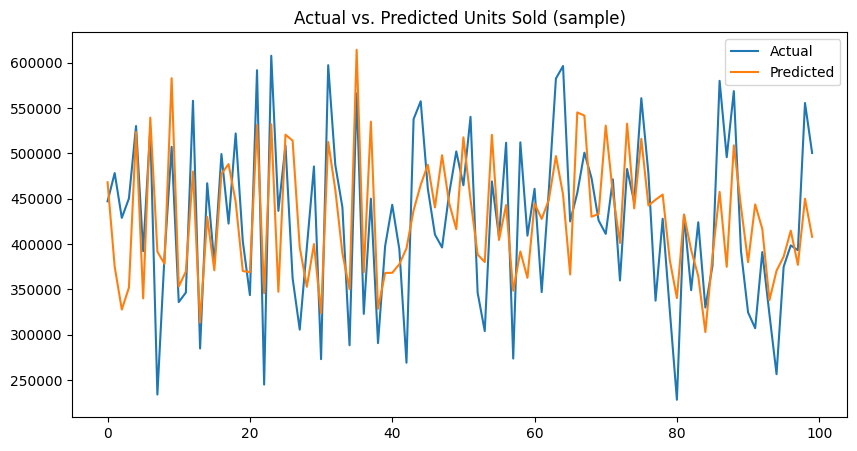

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test.values[:100], label='Actual')
plt.plot(predictions[:100], label='Predicted')
plt.legend()
plt.title("Actual vs. Predicted Units Sold (sample)")
plt.show()

